In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Thermo equation

Statement
$$
\frac{du}{dt} = \frac{d^2u}{dx^2} + f(x, t),\\
0 < x < 1, 0 < t \leq T,\\
u(x, 0) = u_0(x),\\
u(0, t) = y_1(t),\\
u(1, t) = y_2(t)
$$

We are going to solve this problem with next substitutions
$$
f(x, t) = \frac{1}{2} x^2 - t,\\
u(x, 0) = x,\\
u(0, t) = 0,\\
u(1, t) = \frac{1}{2} t + 1,\\
T = 5, N = 10, K = 8
$$

In [2]:
T, N, K = 5, 10, 8
x = np.linspace(0, 1, N)
t = np.linspace(0, T, K)
h, tau = 1/(N - 1), T/(K - 1)
u0 = 1*x
y1 = np.zeros_like(t)
y2 = 1/2*t + 1
xv, tv = np.meshgrid(x, t, sparse=True)
f = xv**2 / 2 - tv

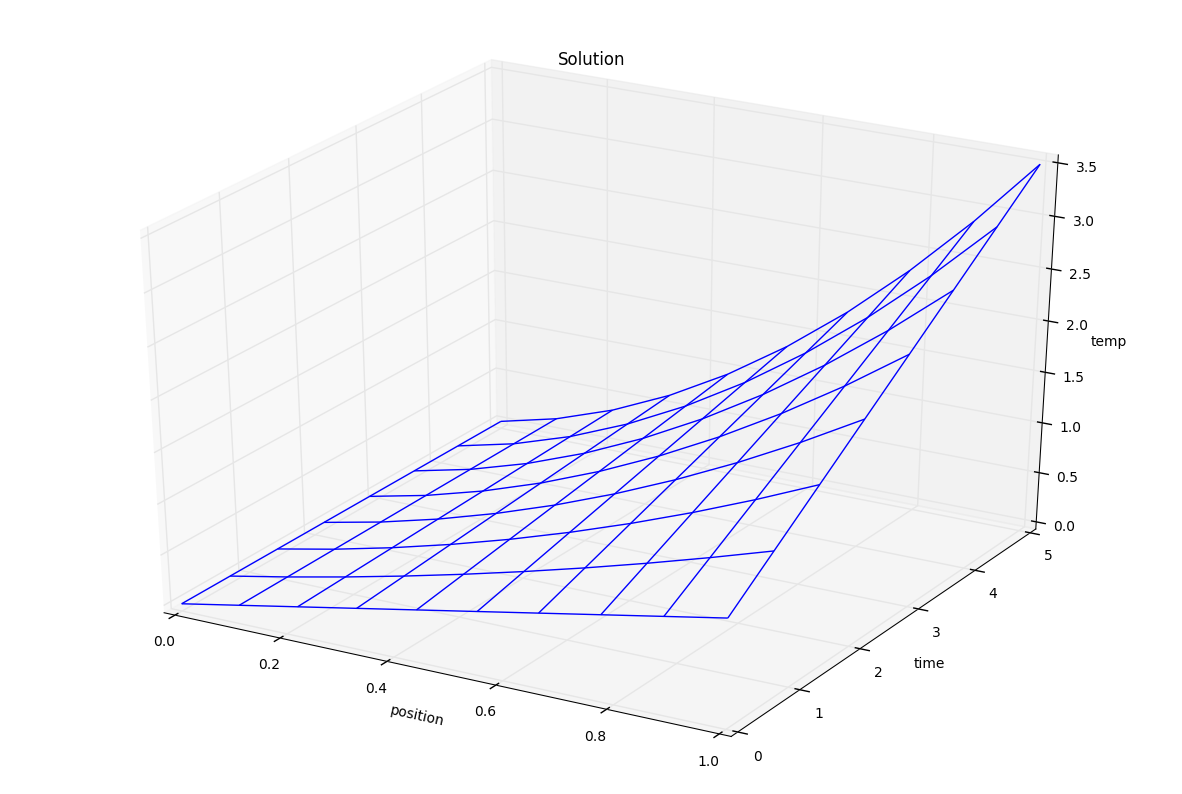

In [3]:
u_ans = xv**2 / 2 * tv + xv

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection = '3d')
ax.plot_wireframe(xv, tv, u_ans)
ax.set_xlabel('position')
ax.set_ylabel('time')
ax.set_zlabel('temp')
ax.set_title('Solution')
plt.show()

## Explicit scheme

In [4]:
def explicit(h, tau, u0, y1, y2, f):
    K = y1.size
    N = u0.size
    y = np.empty((K, N))
    y[0, :] = u0
    y[:, 0] = y1
    y[:, N - 1] = y2
    for j in range(1, K):
        for i in range(1, N - 1):
            y[j, i] = y[j - 1, i] + tau*(y[j - 1, i + 1] - 2*y[j - 1, i] + y[j - 1, i - 1])/h**2 + tau*f[j - 1, i]
    return y

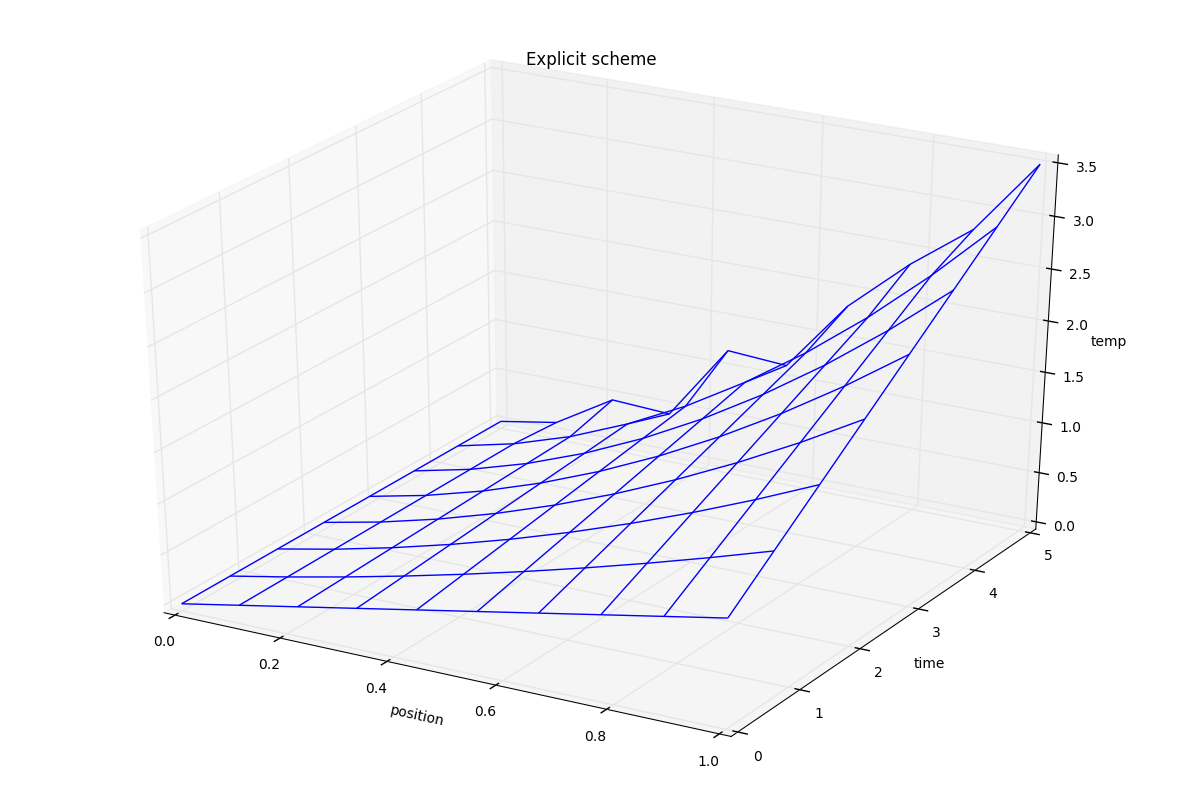

In [5]:
u_exp = explicit(h, tau, u0, y1, y2, f)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection = '3d')
ax.plot_wireframe(xv, tv, u_exp)
ax.set_xlabel('position')
ax.set_ylabel('time')
ax.set_zlabel('temp')
ax.set_title('Explicit scheme')
plt.show()

In [6]:
np.linalg.norm(u_exp - u_ans)

0.3934229075686736

## Implicit scheme

In [7]:
def thomas(a, b, c, d):
    n = len(d)
    A = np.empty_like(d)
    B = np.empty_like(d)
    A[0] = -c[0]/b[0]
    B[0] = d[0]/b[0]
    for i in range(1, n):
        A[i] = -c[i] / (b[i] + a[i]*A[i - 1])
        B[i] = (d[i] - a[i]*B[i - 1])/(b[i] + a[i]*A[i - 1])
    y = np.empty_like(d)
    y[n - 1] = B[n - 1]
    for i in range(n - 2, -1, -1):
        y[i] = A[i]*y[i + 1] + B[i]
    return y

In [8]:
def implicit(h, tau, u0, y1, y2, f):
    K = y1.size
    N = u0.size
    y = np.empty((K, N))
    y[0, :] = u0
    y[:, 0] = y1
    y[:, N - 1] = y2
    for j in range(1, K):
        a = np.ones(N - 2) * 1/h**2
        a[0] = 0
        b = np.ones(N - 2) * -(1/tau + 2/h**2)
        c = np.ones(N - 2) * 1/h**2
        c[-1] = 0
        d = -y[j - 1, 1:-1]/tau - f[j, 1:-1]
        d[0] = d[0] - y1[j]/h**2
        d[-1] = d[-1] - y2[j]/h**2
        y[j, 1:-1] = thomas(a, b, c, d)
    return y

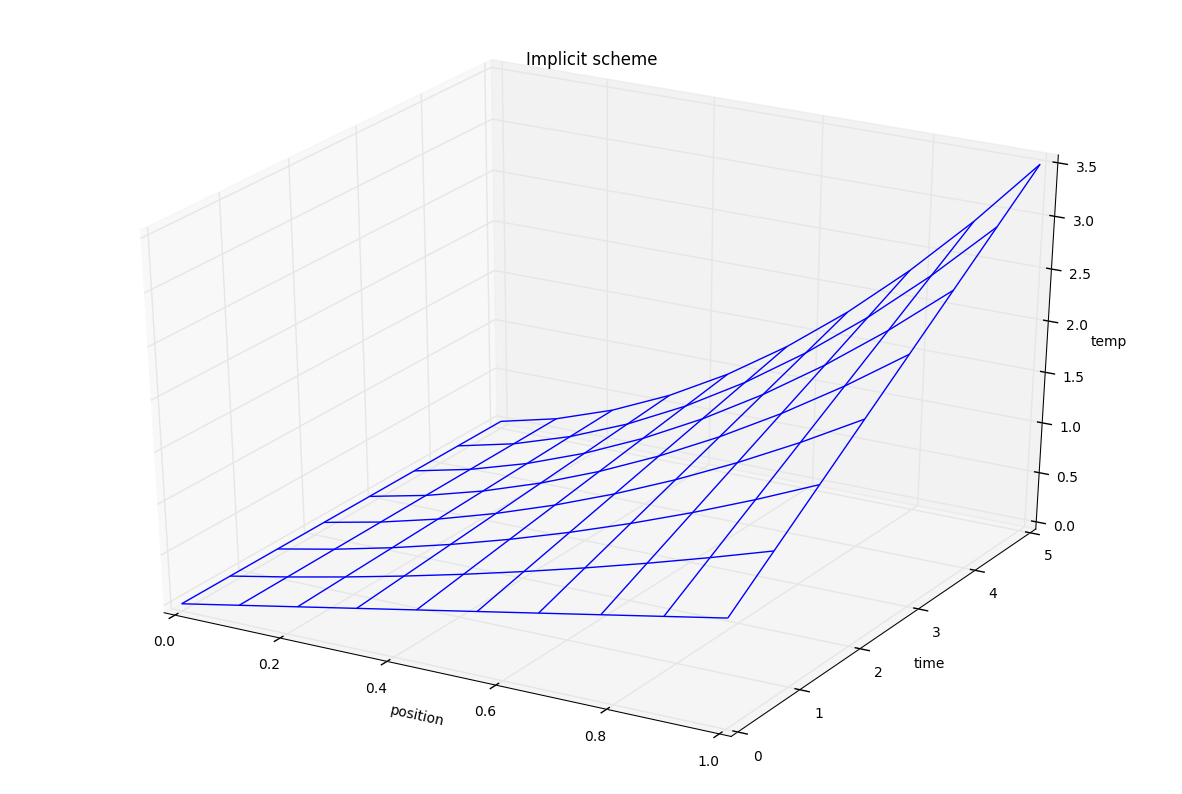

In [9]:
u_imp = implicit(h, tau, u0, y1, y2, f)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection = '3d')
ax.plot_wireframe(xv, tv, u_imp)
ax.set_xlabel('position')
ax.set_ylabel('time')
ax.set_zlabel('temp')
ax.set_title('Implicit scheme')
plt.show()

In [10]:
np.linalg.norm(u_imp - u_ans)

5.9472757305055619e-15

## Stability of solutions

Let's see how error depends on K

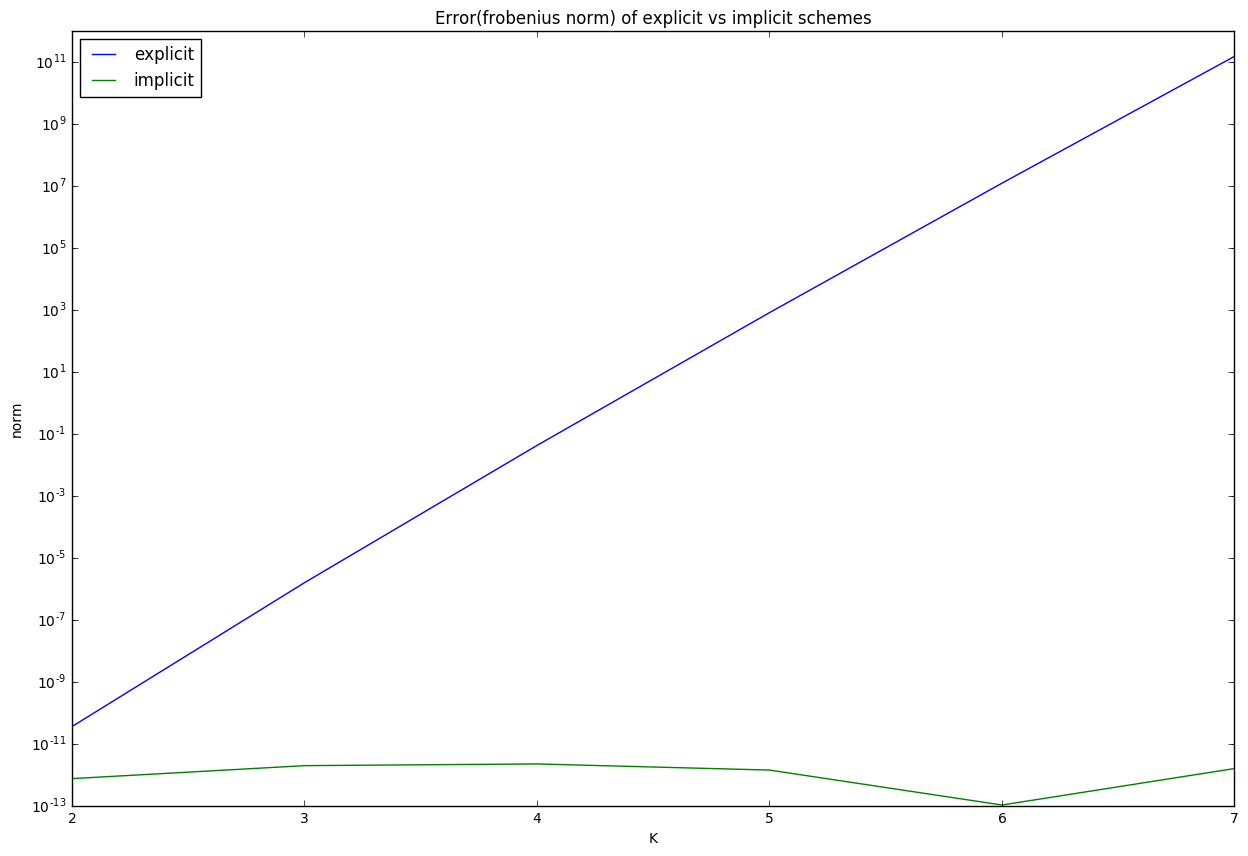

In [11]:
N = 100
Ks = range(2, 8)
err_exp = []
err_imp = []

for K in Ks:
    x = np.linspace(0, 1, N)
    t = np.linspace(0, T, K)
    h, tau = 1/(N - 1), T/(K - 1)
    u0 = 1*x
    y1 = np.zeros_like(t)
    y2 = 1/2*t + 1
    xv, tv = np.meshgrid(x, t, sparse=True)
    f = xv**2 / 2 - tv
    
    u_ans = xv**2 / 2 * tv + xv
    u_exp = explicit(h, tau, u0, y1, y2, f)
    u_imp = implicit(h, tau, u0, y1, y2, f)
    err_exp.append(np.linalg.norm(u_exp - u_ans))
    err_imp.append(np.linalg.norm(u_imp - u_ans))

plt.figure(figsize=(15, 10))
plt.semilogy(Ks, err_exp, Ks, err_imp)
plt.legend(['explicit', 'implicit'], loc='best')
plt.xlabel('K')
plt.ylabel('norm')
plt.title('Error(frobenius norm) of explicit vs implicit schemes')
plt.show()

This show's us that solutions of explicit scheme are **unstable**, while solutions using implicit scheme are **stable**